In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from model_config import ModelConfig
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2022-03-21 10:47:49.852200: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-21 10:47:49.852235: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
transition_window =10

warmup_start = '20210421'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

# Learning rate
learning_rate = 0.001

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)
vax_statuses = [Vax.yes, Vax.no]
x_train = tf.cast(df.loc[train_start:train_end,'Rt'].values, dtype=tf.float32)
x_test = tf.cast(df.loc[train_start:test_end,'Rt'].values, dtype=tf.float32)


y_train = {}
y_train['G_in'] = tf.cast(df.loc[train_start:train_end,'general_ward_in'], dtype=tf.float32)
y_train['G_count'] = tf.cast(df.loc[train_start:train_end,'general_ward_count'], dtype=tf.float32)
y_train['I_count'] = tf.cast(df.loc[train_start:train_end,'icu_count'], dtype=tf.float32)
y_train['D_in'] = tf.cast(df.loc[train_start:train_end,'deaths_covid'], dtype=tf.float32) + 1

y_test = {}
y_test['G_in'] = tf.cast(df.loc[train_start:test_end,'general_ward_in'], dtype=tf.float32)
y_test['G_count'] = tf.cast(df.loc[train_start:test_end,'general_ward_count'], dtype=tf.float32)
y_test['I_count'] = tf.cast(df.loc[train_start:test_end,'icu_count'], dtype=tf.float32)
y_test['D_in'] = tf.cast(df.loc[train_start:test_end,'deaths_covid'], dtype=tf.float32)

2022-03-21 10:47:53.243611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-21 10:47:53.243846: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-21 10:47:53.243896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-21 10:47:53.243930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-21 10:47:53.243961: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [4]:
config = ModelConfig.from_json('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/after_training_eff_mod.json')

In [5]:
config

In [6]:
model = CovidModel([Vax.no, Vax.yes], [Comp.A, Comp.M, Comp.G, Comp.GR, Comp.I, Comp.IR, Comp.D],
                 transition_window,
                config, posterior_samples=1000, debug_disable_theta=False,
                  fix_variance=True)

pre_training_preds=model.call(x_train)

2022-03-21 10:48:36.759211: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [7]:
loss = LogPoissonProb() 
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,#beta_1=0.1, beta_2=0.1
)
#loss((y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in']), pre_training_preds)

In [8]:
logging_callbacks = get_logging_callbacks('/mnt/c/Users/kheut/logs/covid/new_vax_model_small_mod/')

2022-03-21 10:48:37.024734: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-21 10:48:37.024774: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-21 10:48:37.025917: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-03-21 10:48:37.026243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2022-03-21 10:48:37.026350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory
2022-03-21 10:48:37.026366: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be 

In [9]:
model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
model.fit(x=np.asarray([x_train]), y=np.asarray([(y_train['G_count'], y_train['G_in'], y_train['I_count'], y_train['D_in'])]),
         epochs=2000, batch_size=0,
        callbacks=logging_callbacks)

Epoch 1/2000
G count: -24.10477638244629
G in: -9.6259126663208
I count: -7.3589372634887695
D in: -3.269740581512451


2022-03-21 10:49:13.709363: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


1/1 [==============================] - 39s 39s/step - loss: 87.7316
Epoch 2/2000


2022-03-21 10:49:16.390549: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-21 10:49:16.390584: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-21 10:49:16.390864: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


G count: -23.03982162475586
G in: -9.567717552185059
I count: -7.631920337677002
D in: -3.255854368209839
1/1 [==============================] - ETA: 0s - loss: 86.7390

2022-03-21 10:50:02.180124: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-21 10:50:02.381219: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2022-03-21 10:50:05.822717: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-03-21 10:50:14.268830: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-21 10:50:22.815905: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /mnt/c/Users/kheut/logs/covid/new_vax_model_small_mod/train/plugins/profile/2022_03_21_10_50_14

2022-03-21 10:50:23.990194: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /mnt/c/Users/kheut/logs/covid/new_vax_model_small_mod/train/plugins/pr

1/1 [==============================] - 71s 71s/step - loss: 86.7390
Epoch 3/2000
G count: -22.129966735839844
G in: -9.465934753417969
I count: -7.68442440032959
D in: -3.2432198524475098
1/1 [==============================] - 37s 37s/step - loss: 85.5196
Epoch 4/2000
G count: -21.660432815551758
G in: -9.552103042602539
I count: -7.533170700073242
D in: -3.242335796356201
1/1 [==============================] - 37s 37s/step - loss: 85.0313
Epoch 5/2000
G count: -20.877775192260742
G in: -9.49572467803955
I count: -7.38856840133667
D in: -3.238499402999878
1/1 [==============================] - 37s 37s/step - loss: 83.7466
Epoch 6/2000
G count: -20.138792037963867
G in: -9.28923225402832
I count: -7.564390182495117
D in: -3.210723876953125
1/1 [==============================] - 37s 37s/step - loss: 82.9905
Epoch 7/2000
G count: -19.52939796447754
G in: -9.405335426330566
I count: -7.589492321014404
D in: -3.2282299995422363
1/1 [==============================] - 37s 37s/step - loss: 82.

G count: -15.617682456970215
G in: -8.181916236877441
I count: -7.323260307312012
D in: -2.9452593326568604
1/1 [==============================] - 37s 37s/step - loss: 75.7779
Epoch 47/2000
G count: -15.4240083694458
G in: -8.11424446105957
I count: -7.495148181915283
D in: -2.9330904483795166
1/1 [==============================] - 38s 38s/step - loss: 75.6692
Epoch 48/2000
G count: -15.66010570526123
G in: -8.162843704223633
I count: -7.357476234436035
D in: -2.934554100036621
1/1 [==============================] - 37s 37s/step - loss: 75.7635
Epoch 49/2000
G count: -15.265339851379395
G in: -8.085925102233887
I count: -7.443228721618652
D in: -2.9270224571228027
1/1 [==============================] - 39s 39s/step - loss: 75.2865
Epoch 50/2000
G count: -15.444437026977539
G in: -8.019518852233887
I count: -7.49717378616333
D in: -2.905013084411621
1/1 [==============================] - 42s 42s/step - loss: 75.4926
Epoch 51/2000
G count: -15.253055572509766
G in: -8.122090339660645
I c

1/1 [==============================] - 37s 37s/step - loss: 73.8570
Epoch 90/2000
G count: -14.472864151000977
G in: -7.4022626876831055
I count: -7.19544792175293
D in: -2.7258148193359375
1/1 [==============================] - 37s 37s/step - loss: 73.9429
Epoch 91/2000
G count: -14.816524505615234
G in: -7.281134605407715
I count: -7.232711315155029
D in: -2.708284854888916
1/1 [==============================] - 37s 37s/step - loss: 74.2178
Epoch 92/2000
G count: -14.648543357849121
G in: -7.230597972869873
I count: -7.202654838562012
D in: -2.6971793174743652
1/1 [==============================] - 37s 37s/step - loss: 73.8022
Epoch 93/2000
G count: -14.83455753326416
G in: -7.185024261474609
I count: -7.159132480621338
D in: -2.690938949584961
1/1 [==============================] - 37s 37s/step - loss: 73.9579
Epoch 94/2000
G count: -14.67451000213623
G in: -7.137863636016846
I count: -7.53670597076416
D in: -2.6769063472747803
1/1 [==============================] - 37s 37s/step - l

1/1 [==============================] - 38s 38s/step - loss: 72.4678
Epoch 133/2000
G count: -14.161798477172852
G in: -6.566192626953125
I count: -7.134720325469971
D in: -2.5395348072052
1/1 [==============================] - 37s 37s/step - loss: 72.6064
Epoch 134/2000
G count: -14.385333061218262
G in: -6.467288494110107
I count: -7.146605014801025
D in: -2.514127731323242
1/1 [==============================] - 37s 37s/step - loss: 72.9137
Epoch 135/2000
G count: -14.1768217086792
G in: -6.458921432495117
I count: -7.300860404968262
D in: -2.5088791847229004
1/1 [==============================] - 37s 37s/step - loss: 72.5913
Epoch 136/2000
G count: -13.933893203735352
G in: -6.475196361541748
I count: -7.015209197998047
D in: -2.5164356231689453
1/1 [==============================] - 38s 38s/step - loss: 72.2074
Epoch 137/2000
G count: -14.601325988769531
G in: -6.439521312713623
I count: -6.790111541748047
D in: -2.4994728565216064
1/1 [==============================] - 39s 39s/step

1/1 [==============================] - 37s 37s/step - loss: 71.9404
Epoch 176/2000
G count: -14.197835922241211
G in: -5.950352668762207
I count: -6.902690887451172
D in: -2.3828864097595215
1/1 [==============================] - 37s 37s/step - loss: 71.8662
Epoch 177/2000
G count: -14.14340591430664
G in: -5.906455039978027
I count: -7.050638675689697
D in: -2.386274576187134
1/1 [==============================] - 37s 37s/step - loss: 72.0292
Epoch 178/2000
G count: -14.233929634094238
G in: -5.946915149688721
I count: -6.90587854385376
D in: -2.383342742919922
1/1 [==============================] - 37s 37s/step - loss: 71.6970
Epoch 179/2000
G count: -13.93167781829834
G in: -5.904272556304932
I count: -6.889514446258545
D in: -2.378253936767578
1/1 [==============================] - 39s 39s/step - loss: 71.7250
Epoch 180/2000
G count: -14.406122207641602
G in: -5.9183878898620605
I count: -7.168915271759033
D in: -2.372694253921509
1/1 [==============================] - 41s 41s/step

1/1 [==============================] - 39s 39s/step - loss: 71.3395
Epoch 219/2000
G count: -13.9027738571167
G in: -5.522087097167969
I count: -6.9482102394104
D in: -2.2808055877685547
1/1 [==============================] - 38s 38s/step - loss: 71.3438
Epoch 220/2000
G count: -13.88430404663086
G in: -5.4752397537231445
I count: -7.031662464141846
D in: -2.285701274871826
1/1 [==============================] - 39s 39s/step - loss: 71.2439
Epoch 221/2000
G count: -14.192336082458496
G in: -5.52019739151001
I count: -6.791210174560547
D in: -2.2921316623687744
1/1 [==============================] - 38s 38s/step - loss: 71.4282
Epoch 222/2000
G count: -13.758731842041016
G in: -5.463947296142578
I count: -6.9943647384643555
D in: -2.2838265895843506
1/1 [==============================] - 39s 39s/step - loss: 71.1095
Epoch 223/2000
G count: -13.9266996383667
G in: -5.489128589630127
I count: -6.736104488372803
D in: -2.289921283721924
1/1 [==============================] - 39s 39s/step -

1/1 [==============================] - 40s 40s/step - loss: 70.6793
Epoch 262/2000
G count: -13.545783042907715
G in: -5.198321342468262
I count: -6.837881565093994
D in: -2.2333037853240967
1/1 [==============================] - 38s 38s/step - loss: 70.7587
Epoch 263/2000
G count: -13.435845375061035
G in: -5.147950172424316
I count: -6.698122978210449
D in: -2.2150137424468994
1/1 [==============================] - 38s 38s/step - loss: 70.2962
Epoch 264/2000
G count: -13.715468406677246
G in: -5.225439548492432
I count: -6.843611240386963
D in: -2.23022723197937
1/1 [==============================] - 39s 39s/step - loss: 70.9610
Epoch 265/2000
G count: -13.459967613220215
G in: -5.194653511047363
I count: -6.843493461608887
D in: -2.223238706588745
1/1 [==============================] - 39s 39s/step - loss: 70.5134
Epoch 266/2000
G count: -13.795465469360352
G in: -5.171923637390137
I count: -6.906370639801025
D in: -2.2107558250427246
1/1 [==============================] - 38s 38s/s

1/1 [==============================] - 43s 43s/step - loss: 70.2967
Epoch 305/2000
G count: -13.417798042297363
G in: -5.012486457824707
I count: -6.79116678237915
D in: -2.1911420822143555
1/1 [==============================] - 45s 45s/step - loss: 70.2437
Epoch 306/2000
G count: -13.37917709350586
G in: -4.978996753692627
I count: -6.849760055541992
D in: -2.1857826709747314
1/1 [==============================] - 46s 46s/step - loss: 70.2925
Epoch 307/2000
G count: -13.543861389160156
G in: -4.991311550140381
I count: -6.722177028656006
D in: -2.1875698566436768
1/1 [==============================] - 48s 48s/step - loss: 70.4478
Epoch 308/2000
G count: -13.506548881530762
G in: -4.974830150604248
I count: -6.939546585083008
D in: -2.1871416568756104
1/1 [==============================] - 44s 44s/step - loss: 70.5896
Epoch 309/2000
G count: -13.378608703613281
G in: -4.950773239135742
I count: -6.827259063720703
D in: -2.1783835887908936
1/1 [==============================] - 44s 44s/

KeyboardInterrupt: 

In [ ]:
model.variables

Text(0.5, 1.0, 'ICU Count')

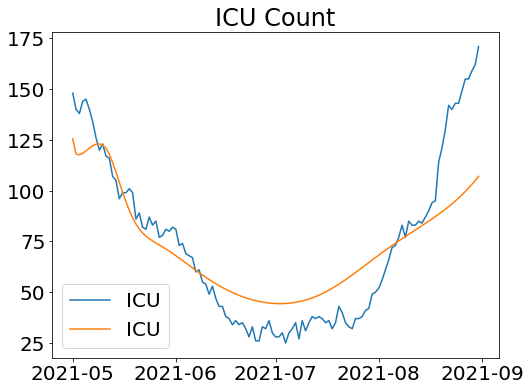

In [41]:
plt.figure(figsize=(8, 6))
preds=tf.reduce_mean(model.call(x_test), axis=-1)
plt.plot(df.loc[train_start:test_end].index.values, y_test['I_count'], label='ICU')
plt.plot(df.loc[train_start:test_end].index.values, preds[0][2], label='ICU')
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('ICU Count')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Gen Count')

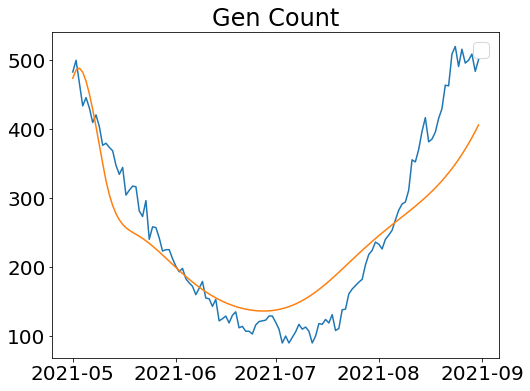

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_count'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][0])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Gen Count')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Gen Influx')

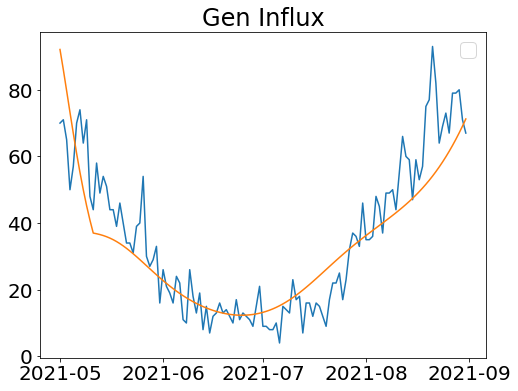

In [43]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_in'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][1])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Gen Influx')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Death Influx')

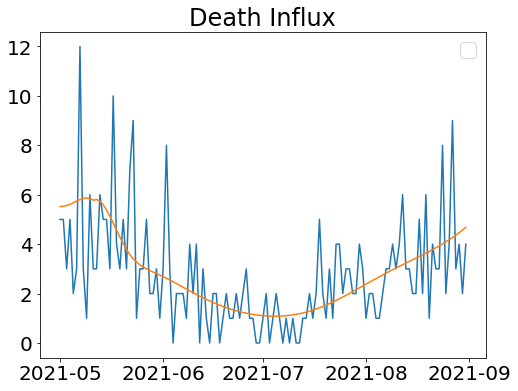

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(df.loc[train_start:test_end].index.values, y_test['D_in'], )
plt.plot(df.loc[train_start:test_end].index.values, preds[0][3])
month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.title('Death Influx')

In [10]:
pred_draws = model.call(x_test)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/kheuton/anaconda3/envs/covid_vax_model/lib/python3.7/site-packages/keras/engine/training.py", line 789, in train_step
    y, y_pred, sample_weight, regularization_losses=self.losses)  File "/home/kheuton/anaconda3/envs/covid_vax_model/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1046, in __call__
    return outputs  File "/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/model.py", line 79, in call
    self._sample_and_reparameterize()  File "/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/model.py", line 1347, in _sample_and_reparameterize
    [dist.log_prob(j + 1) for dist in poisson_I_bar_dist_samples]) /  File "/home/kheuton/anaconda3/envs/covid_vax_model/lib/python3.7/site-packages/tensorflow/python/ut

In [11]:
numpy_draws  = pred_draws.numpy().squeeze()
pred_G_count = numpy_draws[0,:,:]
pred_G_in =  numpy_draws[1,:,:]
pred_I_count = numpy_draws[2,:,:]
pred_D_in = numpy_draws[3,:,:]

In [12]:
pred_G_count_lower, pred_G_count_mean, pred_G_count_upper = (np.percentile(pred_G_count,2.5, axis=1),
                                                             np.mean(pred_G_count, axis=1),
                                                             np.percentile(pred_G_count,97.5, axis=1))

pred_G_in_lower, pred_G_in_mean, pred_G_in_upper = (np.percentile(pred_G_in,2.5, axis=1),
                                                             np.mean(pred_G_in, axis=1),
                                                             np.percentile(pred_G_in,97.5, axis=1))

pred_I_count_lower, pred_I_count_mean, pred_I_count_upper = (np.percentile(pred_I_count,2.5, axis=1),
                                                             np.mean(pred_I_count, axis=1),
                                                             np.percentile(pred_I_count,97.5, axis=1))

pred_D_in_lower, pred_D_in_mean, pred_D_in_upper = (np.percentile(pred_D_in,2.5, axis=1),
                                                             np.mean(pred_D_in, axis=1),
                                                             np.percentile(pred_D_in,97.5, axis=1))

Text(0.5, 1.0, 'General Ward Census')

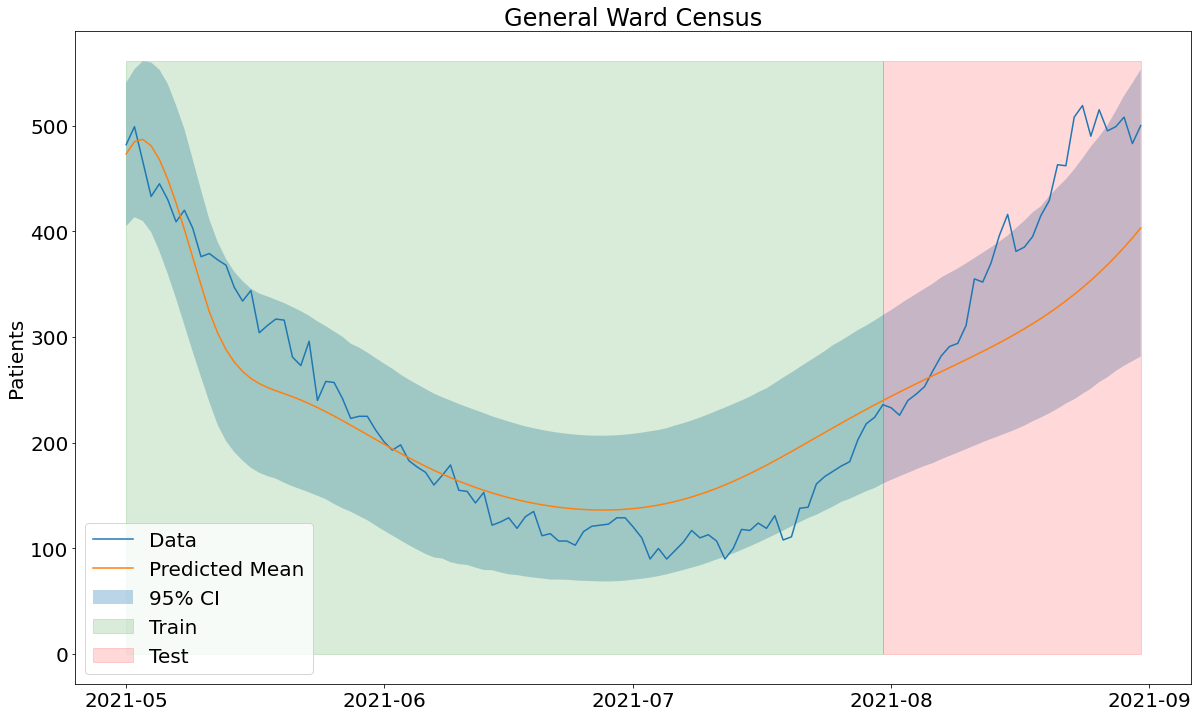

In [83]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_count'], label='Data')
plt.plot(df.loc[train_start:test_end].index.values, pred_G_count_mean, label='Predicted Mean')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_G_count_lower, pred_G_count_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_G_count_upper), max(y_test['G_count']))
plt.fill_between(df.loc[train_start:train_end].index.values,0,max_y, alpha=0.15, color='green', label='Train')
plt.fill_between(df.loc[train_end:test_end].index.values,0,max_y, alpha=0.15, color='red', label='Test')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('General Ward Census')

Text(0.5, 1.0, 'General Ward Census')

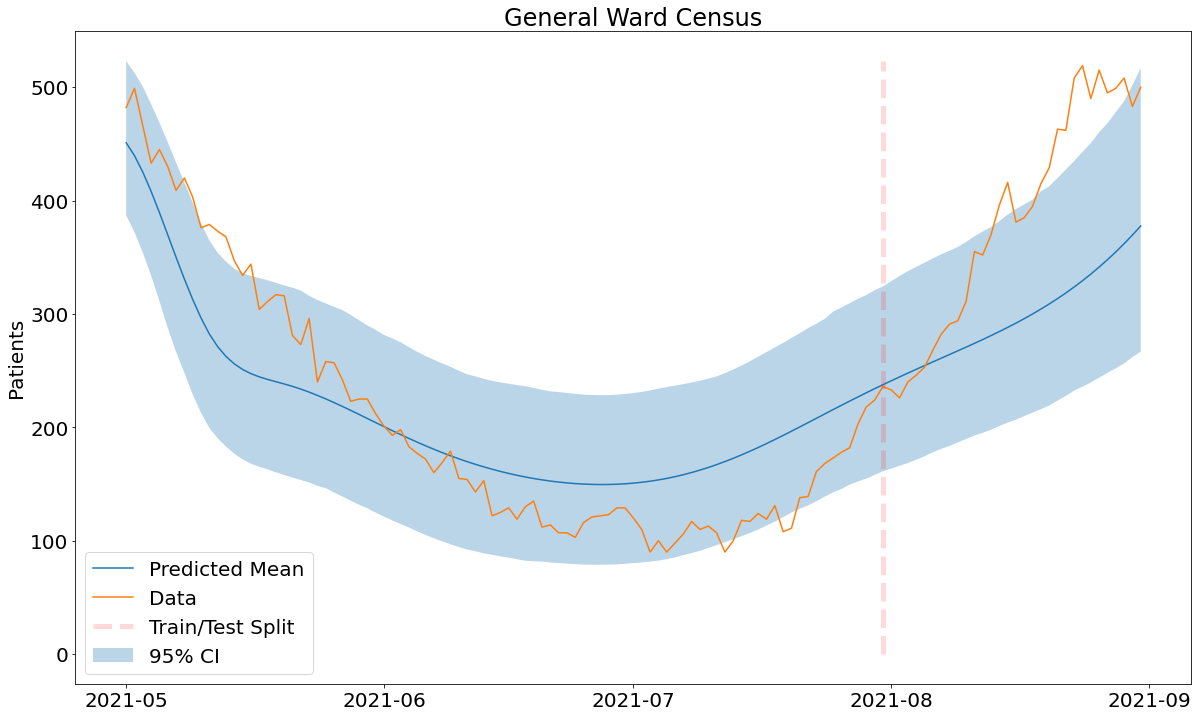

In [13]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, pred_G_count_mean, label='Predicted Mean')
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_count'], label='Data')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_G_count_lower, pred_G_count_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_G_count_upper), max(y_test['G_count']))
plt.plot([df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values], [0,max_y],
         '--', color='red',linewidth=5, alpha=0.15, label='Train/Test Split')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('General Ward Census')
#plt.savefig('G_count.png')

Text(0.5, 1.0, 'General Ward Daily New Patients')

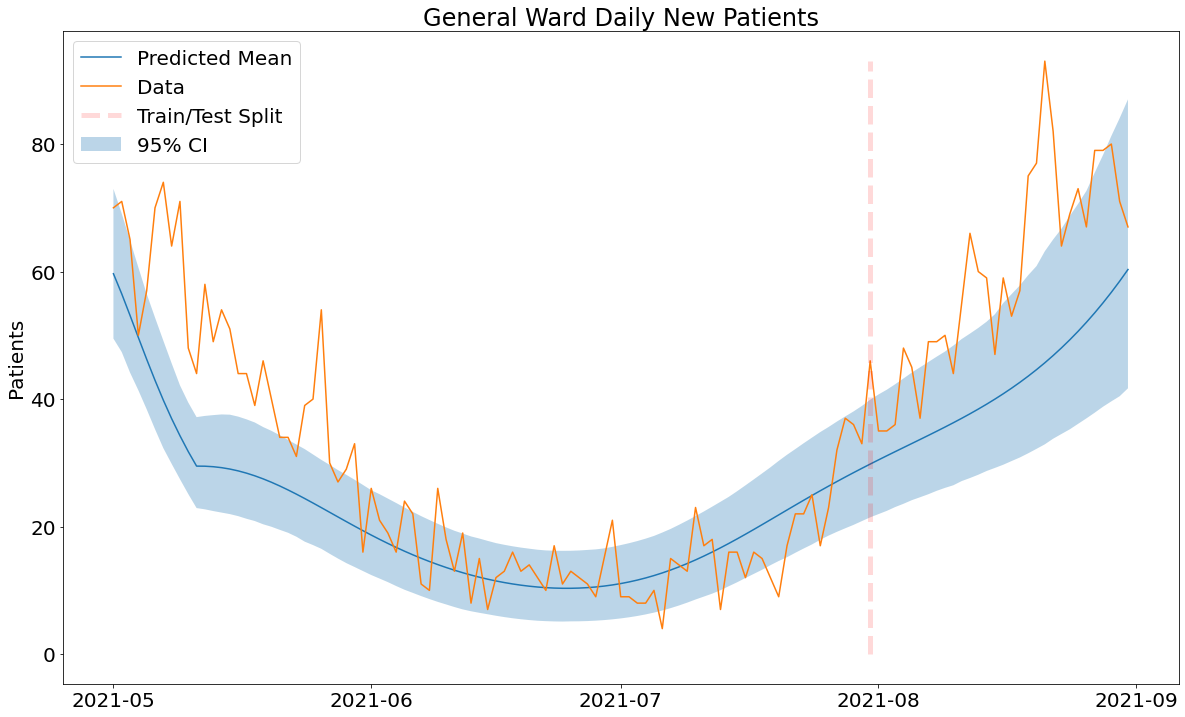

In [14]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, pred_G_in_mean, label='Predicted Mean')
plt.plot(df.loc[train_start:test_end].index.values, y_test['G_in'], label='Data')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_G_in_lower, pred_G_in_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_G_in_upper), max(y_test['G_in']))
plt.plot([df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values], [0,max_y],
         '--', color='red',linewidth=5, alpha=0.15, label='Train/Test Split')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('General Ward Daily New Patients')
#plt.savefig('G_in.png')

Text(0.5, 1.0, 'ICU Census')

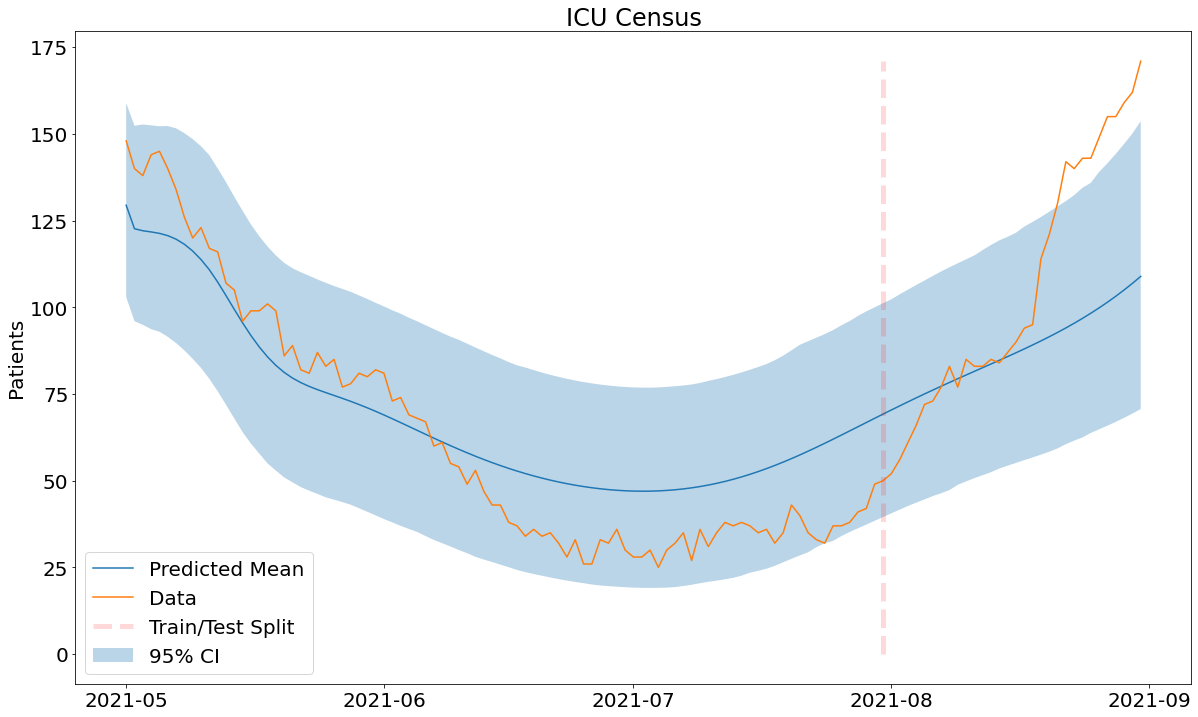

In [15]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, pred_I_count_mean, label='Predicted Mean')
plt.plot(df.loc[train_start:test_end].index.values, y_test['I_count'], label='Data')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_I_count_lower, pred_I_count_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_I_count_upper), max(y_test['I_count']))
plt.plot([df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values], [0,max_y],
         '--', color='red',linewidth=5, alpha=0.15, label='Train/Test Split')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('ICU Census')
#plt.savefig('I_count.png')

Text(0.5, 1.0, 'Daily Deaths')

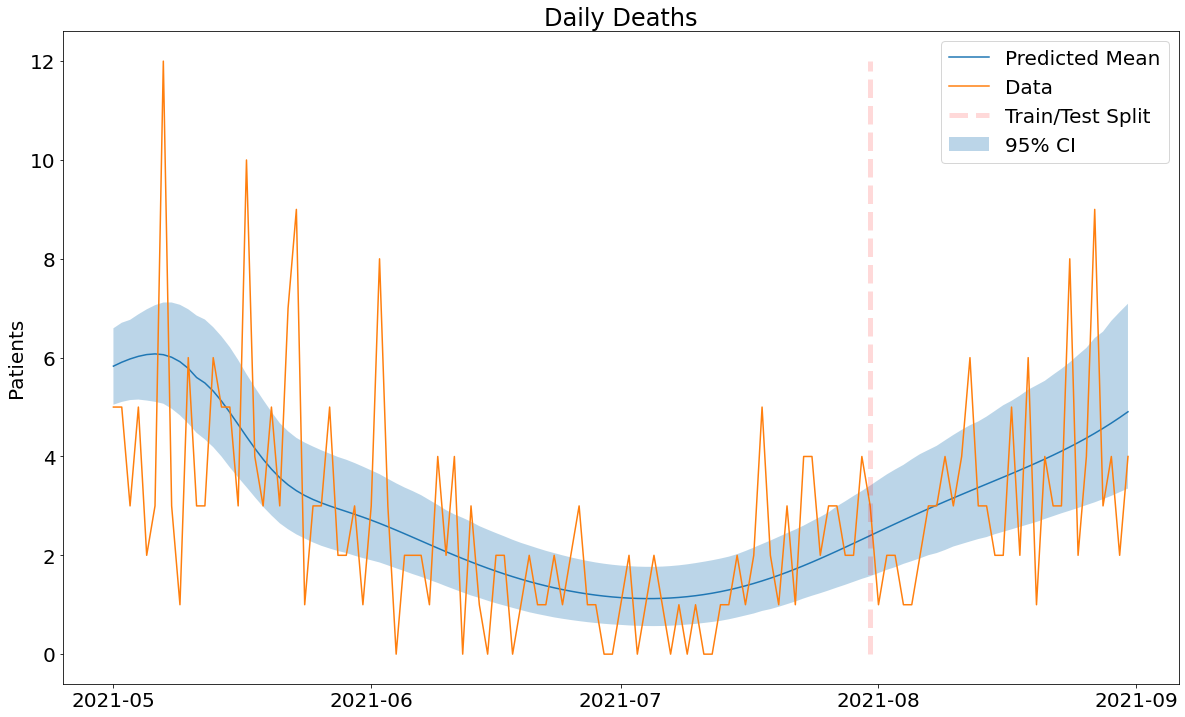

In [16]:
plt.figure(figsize=(20, 12))
plt.plot(df.loc[train_start:test_end].index.values, pred_D_in_mean, label='Predicted Mean')
plt.plot(df.loc[train_start:test_end].index.values, y_test['D_in'], label='Data')
plt.fill_between(df.loc[train_start:test_end].index.values, pred_D_in_lower, pred_D_in_upper,
                label='95% CI', alpha=0.3)

max_y = max(max(pred_D_in_upper), max(y_test['D_in']))
plt.plot([df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values], [0,max_y],
         '--', color='red',linewidth=5, alpha=0.15, label='Train/Test Split')

month_ticks = matplotlib.dates.MonthLocator(interval=1)
ax = plt.gca()
ax.xaxis.set_major_locator(month_ticks)
plt.legend()
plt.ylabel('Patients')
plt.title('Daily Deaths')
#plt.savefig('D_in.png')

In [40]:
new_config.to_json("/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/after_training_eff.json")

In [ ]:
y_train

In [ ]:
model.init_count_G_params

In [ ]:
model.config.init_count_I.value

In [ ]:
new_config = model.config.update_from_model(model)

In [ ]:
new_config.to_json("/mnt/c/Users/kheut/Downloads/fix_after_600.json")

In [ ]:
model.variables

In [ ]:
model.init_count_G_params

In [ ]:
model.variables

In [ ]:
model.init_count_G_samples_constrained[0].numpy().min(), model.init_count_G_samples_constrained[0].numpy().max()

In [ ]:
tfp.bijectors.Softplus.inverse(17/100)

In [ ]:
new_config.init_count_I.value

In [ ]:
model.config.init_count_G.value[1]['scale']

In [ ]:
model.init_count_G_params

In [ ]:
tf.random.normal((1000, ))

In [72]:
[df.loc[train_end:train_end].index.values, df.loc[train_end:train_end].index.values]

[array(['2021-07-31T00:00:00.000000000'], dtype='datetime64[ns]'),
 array(['2021-07-31T00:00:00.000000000'], dtype='datetime64[ns]')]